https://www.linkedin.com/in/oscar-kosar-kosarewicz/# FSA Assignment
 Implement the FSA variable selectionmethod for linear models and binary classification with the logistic loss, as
 described in the slides. Use the parameters s = 0.0001, μ = 30, N iter = 500. Take special care to normalize each column of the X matrix to have zero mean and variance 1 and to use the same mean and standard deviation that you used for normalizing the train set also for normalizing the test set.


#### Import dependencies

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

#### Data loading functions

In [2]:
def get_gisette():
    path = "data/gisette/"   
    
    train_x = np.loadtxt(path+"gisette_train.data")
    train_y = np.loadtxt(path+"gisette_train.labels")
    
    valid_x = np.loadtxt(path+"gisette_valid.data")
    valid_y = np.loadtxt(path+"gisette_valid.labels")
    
    test_x = np.loadtxt(path+"gisette_test.data")

    return train_x, train_y, valid_x, valid_y, test_x



def get_dexter():
    path = "data/dexter/"

    train_x = np.loadtxt(path+"dexter_train.csv", delimiter=',')
    train_y = np.loadtxt(path+"dexter_train.labels")

    valid_x = np.loadtxt(path+"dexter_valid.csv", delimiter=',')
    valid_y = np.loadtxt(path+"dexter_valid.labels")

    return train_x, train_y, valid_x, valid_y

def get_madelon():
    path = "data/MADELON/"

    train_x = np.loadtxt(path + "madelon_train.data")
    train_y = np.loadtxt(path + "madelon_train.labels")
    test_x = np.loadtxt(path + "madelon_valid.data")
    test_y = np.loadtxt(path + "madelon_valid.labels")

    return train_x, train_y, test_x, test_y

#### Normalization function

In [3]:
def normalize(train, *args):
    mean = np.average(train, axis=0)
    standard_deviation = np.std(train, axis=0)
    columns = train, *args
    return tuple(np.divide(column-mean, standard_deviation, where=standard_deviation!=0)
                 for column in columns)



#### Calculate the next iteration's weights

In [4]:
def update_weights(w, x, y):
    learning_rate = 1/x.shape[0]
    return w + learning_rate * L(w, x, y)

def L(w, x, y):
    """
    Gradient of logistic loss function with sparsity-inducing penalty
    """
    s = 0.0001
    return x.T.dot(y-(1/(1+np.exp(-np.dot(x,w))))) + 2 * s * w

def predict(X,w):
    '''
    Predictor function for logistic regression
    '''
    return np.round(1 /(1 + np.exp(-X @ w)))

#### Calculate the number of parameters to keep

In [5]:
def calc_schedule(num_params, k, num_iterations):
    mu = 30
    return [round(k+(num_params-k)*max(0,(num_iterations-2*i)/(2*i*mu+num_iterations)))
            for i in range(1,num_iterations+1)]

#### Eliminate Parameters

In [6]:
def eliminate_parameters(parameters_to_keep, w, x_train, x_test):
    """
    Eliminates the parameters which have the smallest weights so that parameters_to_keep parameter remain
    """
    # list of indexes that would sort the array
    sorted_indexes = np.argsort(w)
    # index thresholds used to eliminate insignificant parameters
    threshold = w.size - parameters_to_keep
    # delete indexes smaller than threshold
    w = np.delete(w, sorted_indexes[sorted_indexes < threshold])
    x_train = np.delete(x_train, sorted_indexes[sorted_indexes < threshold], axis=1)
    x_test = np.delete(x_test, sorted_indexes[sorted_indexes < threshold], axis=1)
    return w, x_train, x_test


#### Train logistic regression model using FSA

In [7]:
def train_fsa(x_train, y_train, x_test, y_test, k):
    iterations = 500
    x_train, x_test = normalize(x_train, x_test)
    # append column of ones for the intercept
    x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))
    # make sure data is binary 0,1 rather than -1,1
    y_train[y_train==-1] = 0
    y_test[y_test==-1] = 0

    w = np.zeros(x_train.shape[1]) # initializing weights to 0
    schedule = calc_schedule(w.size, k, iterations)
    train_scores = []
    test_scores = []
    train_scores.append(1 - accuracy_score(y_train, predict(x_train, w)))
    test_scores.append(1 - accuracy_score(y_test, predict(x_test, w)))
    for parameters_to_keep in schedule:
        if parameters_to_keep == 0:
            break
        w = update_weights(w, x_train, y_train)
        w, x_train, x_test = eliminate_parameters(parameters_to_keep, w, x_train, x_test)
        train_scores.append(1 - accuracy_score(y_train, predict(x_train, w)))
        test_scores.append(1 - accuracy_score(y_test, predict(x_test, w)))
    number_of_features = w.size
    return test_scores, train_scores, number_of_features


#### Plot the error vs iteration and display final error in a table

In [8]:
def plot(features, test_errors, train_errors, train_errors_to_plot, test_errors_to_plot):
    iteration = list(range(len(train_errors_to_plot)))
    plt.plot(iteration, train_errors_to_plot);
    plt.plot(iteration, test_errors_to_plot);
    plt.legend(["Train", "Test"])
    plt.xlabel("Iterations")
    plt.ylabel("Misclassification error")
    plt.title("Error vs iterations with 30 features")
    plt.show()

    plt.plot(features, train_errors)
    plt.plot(features, test_errors)
    plt.legend(["Train", "Test"])
    plt.xlabel("Number of features")
    plt.ylabel("Final misclassification error")
    plt.title("Features vs misclassification error")

    test_errors = [f"{test_error:.3f}" for test_error in test_errors]
    train_errors = [f"{train_error:.3f}" for train_error in train_errors]
    plt.table(cellText=[*zip(features, train_errors, test_errors)], colLabels=['Features', 'Training error', 'Test error'],
              bbox=[0.0,-0.8, 1,.4], edges="closed" )
    plt.show()

def plot_fsa(x_train, y_train, x_test, y_test, thresholds):
    features = []
    train_errors = []
    test_errors = []
    train_errors_to_plot = None
    test_errors_to_plot = None
    for i, threshold in enumerate(thresholds):
        test_error, train_error, num_features = train_fsa(x_train, y_train, x_test, y_test, threshold)
        features.append(num_features)
        train_errors.append(train_error[-1])
        test_errors.append(test_error[-1])
        if i==1:
            train_errors_to_plot = train_error
            test_errors_to_plot = test_error
    plot(features, test_errors, train_errors, train_errors_to_plot, test_errors_to_plot)

## a) Gisette

Using the Gisette data, train a FSA classifier on the training set, starting with β(0) = 0 to select k ∈ {10, 30, 100, 300, 500} features. Plot the training loss vs iteration number for k = 30. Report in a table the misclassification errors on the training and test set for the models obtained for all these k. Plot the misclassification error on the training and test set vs k.

In [9]:
train_x, train_y, test_x, test_y, _ = get_gisette()

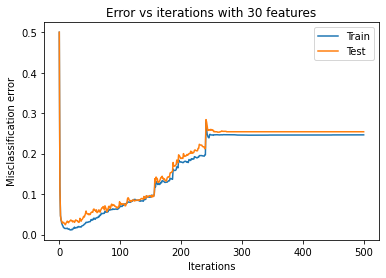

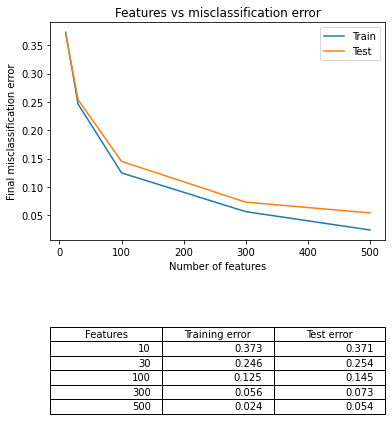

In [10]:
plot_fsa(train_x, train_y, test_x, test_y, [10, 30, 100, 300, 500]);

## b) Dexter
Repeat point a) on the dexter dataset

In [11]:
#train_x, train_y, test_x, test_y = get_dexter()

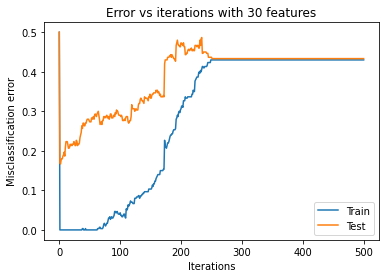

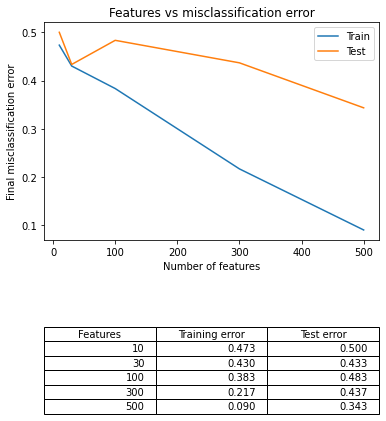

In [12]:
#plot_fsa(train_x, train_y, test_x, test_y, [10, 30, 100, 300, 500]);

## c) Madelon
Repeat point a) on the madelon dataset

In [13]:
train_x, train_y, test_x, test_y = get_madelon()

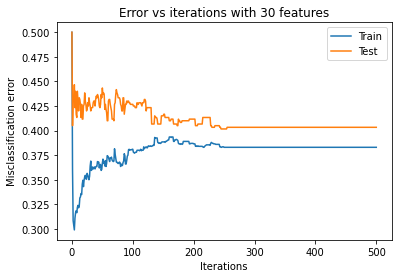

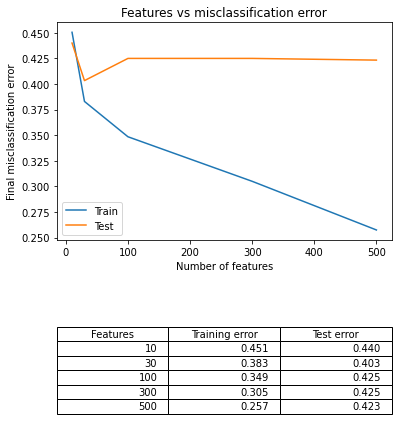

In [14]:
plot_fsa(train_x, train_y, test_x, test_y, [10, 30, 100, 300, 500]);
